### K Nearest Neighbors
He takes a moment out of his busy day to explain what you need to do. "I need a better way to tell which 
of my plans are going to be supported by Congress," he explains. **"Do you think we can get a model of 
Democrats and Republicans in Congress, and which votes separate them the most?"** 

"Yes, we can!" You answer. 

You decide to start by making a nearest-neighbors classifier that can tell Democrats apart from 
Republicans in the Senate.

#### Data
You acquire the data on how everyone in the previous Senate and House of Representatives voted on 
every issue. (These data are available in machine-readable form via voteview.com. We've included it 
in the lab directory, in the files beginning with H110 and S110.) 

- 'name': The name of the Congressperson. 
- 'state': The state they represent. 
- 'party': The party that they were elected under. 
- 'votes': The votes that they cast, as a list of numbers. 1 represents a "yea" vote, -1 represents 
"nay", and 0 represents either that they abstained, were absent, or were not a member of 
Congress at the time. 

In [2]:
from mit.lab4.data_reader import read_congress_data, read_vote_data, vote_info

In [3]:
senate_data = read_congress_data("./mit/lab4/S110.ord")
house_data = read_congress_data("./mit/lab4/H110.ord")

print("Congress senate members S110: ", len(senate_data))
print("Congress house members H110: ", len(house_data))

Congress senate members S110:  102
Congress house members H110:  447


### scikit learn kNN

In [168]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


plt.style.use(["science", "notebook"])

In [169]:
print("votes number sentate: ", len(senate_data[0]["votes"]))

votes number sentate:  655


In [170]:
X = np.array([m["votes"] for m in senate_data])
y = np.array([m["party"] for m in senate_data])

X.shape, y.shape

((102, 655), (102,))

In [186]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.4, random_state=42
)

X_train.shape, y_train.shape

((61, 655), (61,))

In [172]:
X_test.shape, y_test.shape

((41, 655), (41,))

In [173]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [174]:
score_knn = knn.score(X_test, y_test)
score_knn

0.9512195121951219

In [175]:
example = X_test[0][:, np.newaxis].T
knn.predict(example)

array(['Democrat'], dtype='<U11')

In [176]:
y_test[0]

'Democrat'

### Open questions
1. Can we visualize this?
1. What are the most relevant votes? That is, which votes out of the 655
    are actually causally related to the final democrat republican classification
1. Can we tune the KNN classifier parameters?
    1. Cross-validation ??


### Feature importance analysis

In [187]:
samples, dim = X.shape

dim_score_1 = np.empty(dim)

for i in range(1, dim):
    X_train_reduced = X_train[:][:i]
    y_train_reduced = y_train[:i]

    knn = KNeighborsClassifier(n_neighbors=5 if i > 5 else i)
    knn.fit(X_train_reduced, y_train_reduced)

    X_test_reduced = X_test[:][:i]
    y_test_reduced = y_test[:i]

    dim_score_1[i] = knn.score(X_test_reduced, y_test_reduced)


dim_score_2 = np.empty(dim)

for i in range(dim):
    X_train_reduced = np.delete(X_train, i, axis=1)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_reduced, y_train)

    X_test_reduced = np.delete(X_test, i, axis=1)


    dim_score_2[i] = knn.score(X_test_reduced, y_test)    

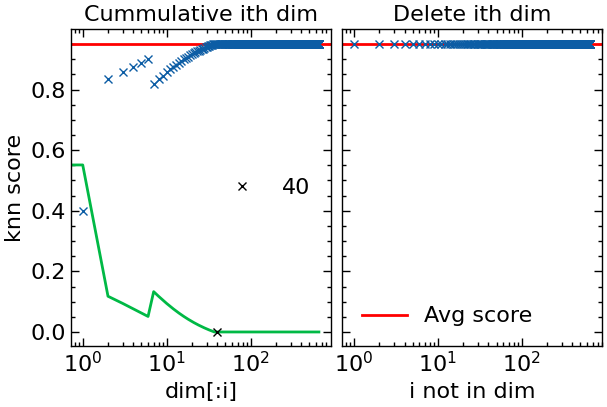

In [188]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4), sharey=True)

dim_score_1 = dim_score_1[4:]  # removing scores that don't belong to k=5 NN
ax1.axhline(y=score_knn, color="r", linestyle="-")
ax1.plot(dim_score_1, "x")
ax1.set_xscale("log")
ax1.set_title("Cummulative ith dim")
ax1.set_ylabel("knn score")
ax1.set_xlabel("dim[:i]")

ax1.plot(score_knn-dim_score_1)
ax1.plot(40, 0, "kx", label="40")
ax1.legend()


ax2.axhline(y=score_knn, color="r", linestyle="-", label="Avg score")
ax2.plot(dim_score_2, "x")
ax2.set_xscale("log")
ax2.set_title("Delete ith dim")
ax2.set_xlabel("i not in dim")
ax2.legend()

plt.tight_layout()
plt.show()

Approximately, 40 out of 655 votations are actually relevant to the final score

* **What happens with votation $i=11$?**

    The score seems to go up and the 7th votation sets the score down again

Let's repeat the experiment removing i=11

In [192]:
dim_score_1 = np.empty(dim)

X_train_copy = np.delete(X_train, 11, axis=1)
X_test_copy = np.delete(X_test, 11, axis=1)

for i in range(1, dim):
    X_train_reduced = X_train_copy[:][:i]
    y_train_reduced = y_train[:i]

    knn = KNeighborsClassifier(n_neighbors=5 if i > 5 else i)
    knn.fit(X_train_reduced, y_train_reduced)

    X_test_reduced = X_test_copy[:][:i]
    y_test_reduced = y_test[:i]

    dim_score_1[i] = knn.score(X_test_reduced, y_test_reduced)

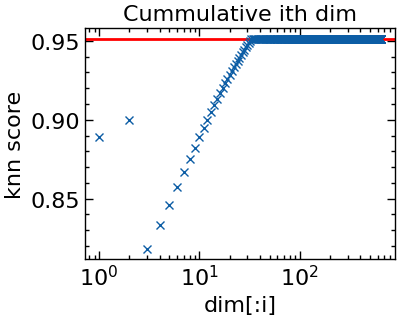

In [194]:
fig, ax = plt.subplots(figsize=(4, 3))

dim_score_1 = dim_score_1[4:]  # removing scores that don't belong to k=5 NN
ax.axhline(y=score_knn, color="r", linestyle="-")
ax.plot(dim_score_1, "x")

ax.set_xscale("log")
ax.set_title("Cummulative ith dim")
ax.set_ylabel("knn score")
ax.set_xlabel("dim[:i]")

plt.show()

### Principal components analysis
PCA plots converts the correlatoins (or lack there of) among all variables into a 2d graph
PC1 axes differences are more important than PC2 axes differences

In [233]:
from sklearn.decomposition import PCA

In [279]:
pca = PCA(n_components=2)
pca.fit(X)


PCA(n_components=2)

In [280]:
X_pca = pca.transform(X)

In [281]:
X_pca.shape

(102, 2)

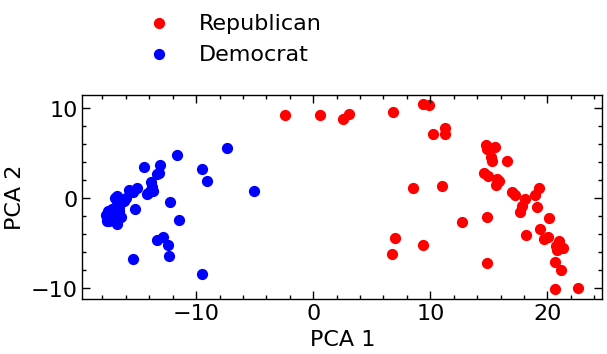

In [282]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

targets = ['Republican', 'Democrat']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    to_keep = y == target
    ax.scatter(X_pca[to_keep][:, 0], X_pca[to_keep][:, 1], c = color, s = 50)


ax.legend(targets, bbox_to_anchor=(0.5, 1.5), fancybox=True)
plt.tight_layout()
plt.show()

#### What are this 'controversial' votations?

In [288]:
np.argmax(pca.components_, axis=1)

array([493, 383], dtype=int64)

In [292]:
vote_data = read_vote_data("./mit/lab4/S110desc.csv")

In [294]:
vote_info(vote_data[493])

'S.Con.Res. 70: Conrad Amdt. No. 4204; To add a deficit-neutral reserve fund for repealing the 1993 increase in the income tax on Social Security benefits.'

In [295]:
vote_info(vote_data[383])


'H.R. 3043: Enzi Amdt. No. 3437; To prohibit the use of funds to modify certain HIV/AIDS funding formulas.'